# Background field
Creation of a climatology using a background field create

In [1]:
using DIVAnd
using PyPlot
using NCDatasets
using PhysOcean
using DataStructures
using PyPlot
using Dates
using Statistics
using Random
using Printf

## Files and directories
For this application we will work on the Baltic Sea.

In [2]:
datadir = "../data/"
datafile = joinpath(datadir, "Baltic_obs.nc")
varname = "salinity"

"salinity"

## Inputs
### Grid and depth levels

In [3]:
Δx = 0.25
Δy = 0.25
lonr = 9.5:Δx:29.25
latr = 53.0:Δy:67.0
timerange = [Date(1900,1,1),Date(2020,12,31)];
depthr = [0.,5., 10., 15., 20., 30.];

### Data
Download if needed.

In [4]:
if !isfile(datafile)
    download("https://dox.ulg.ac.be/index.php/s/h0KlmTNzEp76ari/download", datafile)
end

In [5]:
@time obsval,obslon, obslat, obsdepth, obstime,obsid = DIVAnd.loadobs(Float64, datafile, varname);

 11.148219 seconds (52.71 M allocations: 5.296 GiB, 9.59% gc time)


Check the observation ranges:

In [6]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

┌ Info: Checking ranges for dimensions and observations
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/obsstat.jl:75


              minimum and maximum of obs. dimension 1: (8.972800254821777, 29.135000228881836)
              minimum and maximum of obs. dimension 2: (53.80670166015625, 65.80816650390625)
              minimum and maximum of obs. dimension 3: (0.0, 690.0)
              minimum and maximum of obs. dimension 4: (1899-12-30T00:00:00, 2013-11-07T09:16:00)
                          minimum and maximum of data: (-0.09000000357627869, 36.47800064086914)


#### Quality check based on range

In [7]:
sel = (obsval .<= 40) .& (obsval .>= 0);
obsval = obsval[sel]
obslon = obslon[sel]
obslat = obslat[sel]
obsdepth = obsdepth[sel]
obstime = obstime[sel]
obsid = obsid[sel];

#### Plot unique observation locations

In [8]:
coords = [(x,y) for (x,y) in zip(obslon, obslat)];
coords_u = unique(coords);
@info "Total number of coordinates: $(length(coords))"
@info "Number of unique coordinates (profiles): $(length(coords_u))"
obslon_u = [x[1] for x in coords_u];
obslat_u = [x[2] for x in coords_u];

┌ Info: Total number of coordinates: 11180368
└ @ Main In[8]:3
┌ Info: Number of unique coordinates (profiles): 170227
└ @ Main In[8]:4


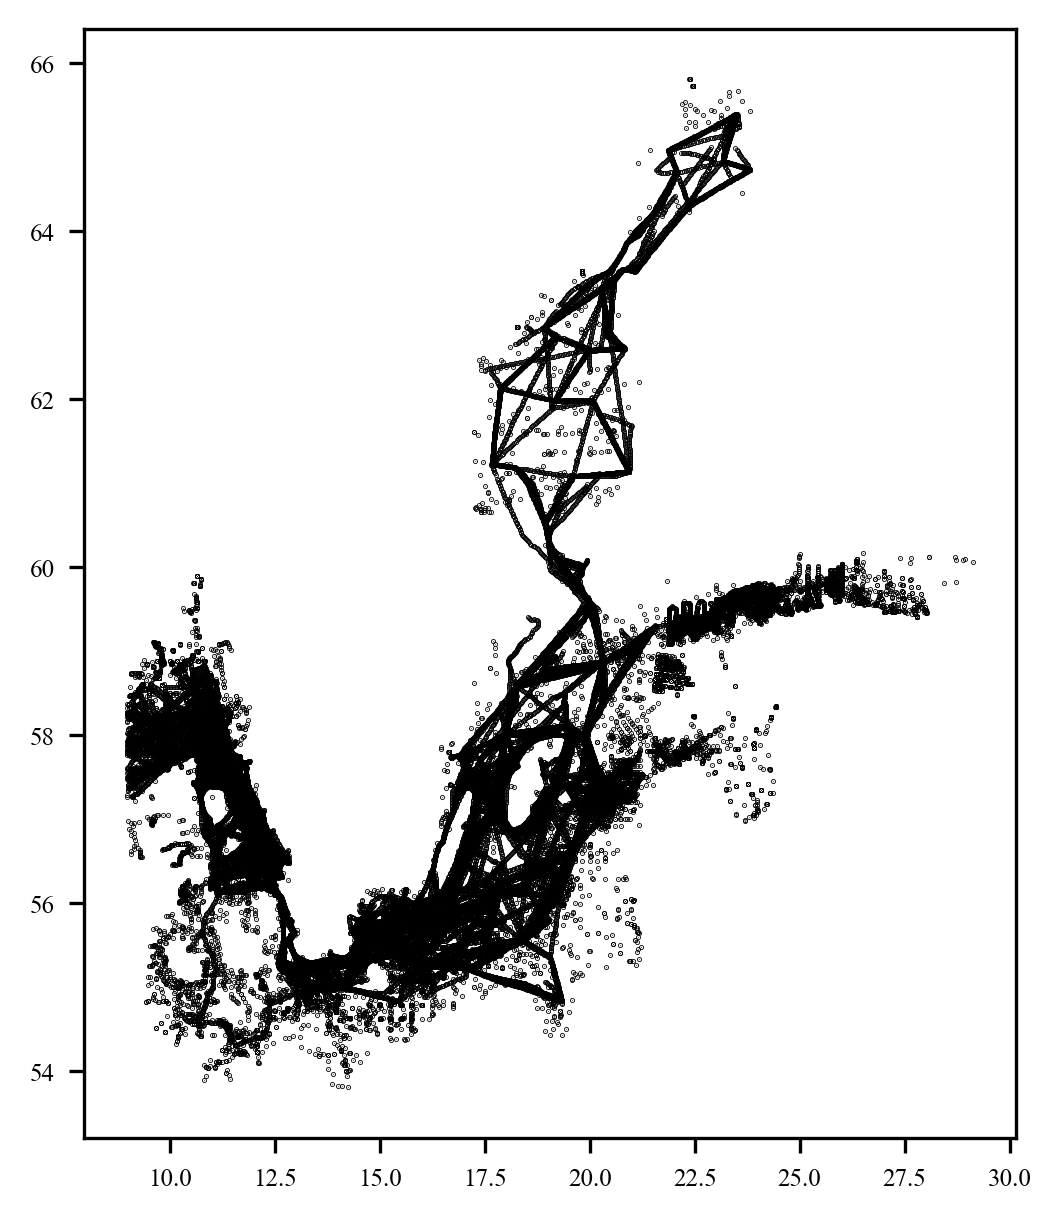

In [9]:
figure()
ax = subplot(1,1,1)
plot(obslon_u, obslat_u, "ko", markersize=.2)
aspect_ratio = 1/cos(mean(latr) * pi/180)
ax.tick_params("both",labelsize=6)
gca().set_aspect(aspect_ratio)

### Bathymetry

In [10]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download", bathname)
else
    @info "Bathymetry file already downloaded"
end
@time bx, by, b = load_bath(bathname, true, lonr, latr);

┌ Info: Bathymetry file already downloaded
└ @ Main In[10]:5


  2.538300 seconds (6.67 M allocations: 338.828 MiB, 8.25% gc time)


#### Plotting

In [11]:
figure()
ax = subplot(1,1,1)
pcolor(bx,by,permutedims(b, [2,1]));
cb = colorbar(orientation="vertical", shrink=0.8)c
cb.ax.tick_params(labelsize=8)
contour(bx,by,permutedims(b, [2,1]), [0, 0.1], colors="k", linewidths=.5)
gca().set_aspect(aspect_ratio)
ax.tick_params("both",labelsize=6)

UndefVarError: UndefVarError: c not defined

#### Land-sea mask

In [12]:
surfwater = b .>= depthr[1]
label = DIVAnd.floodfill(surfwater)
surfmask = label .== 1; # largest area has the label 1

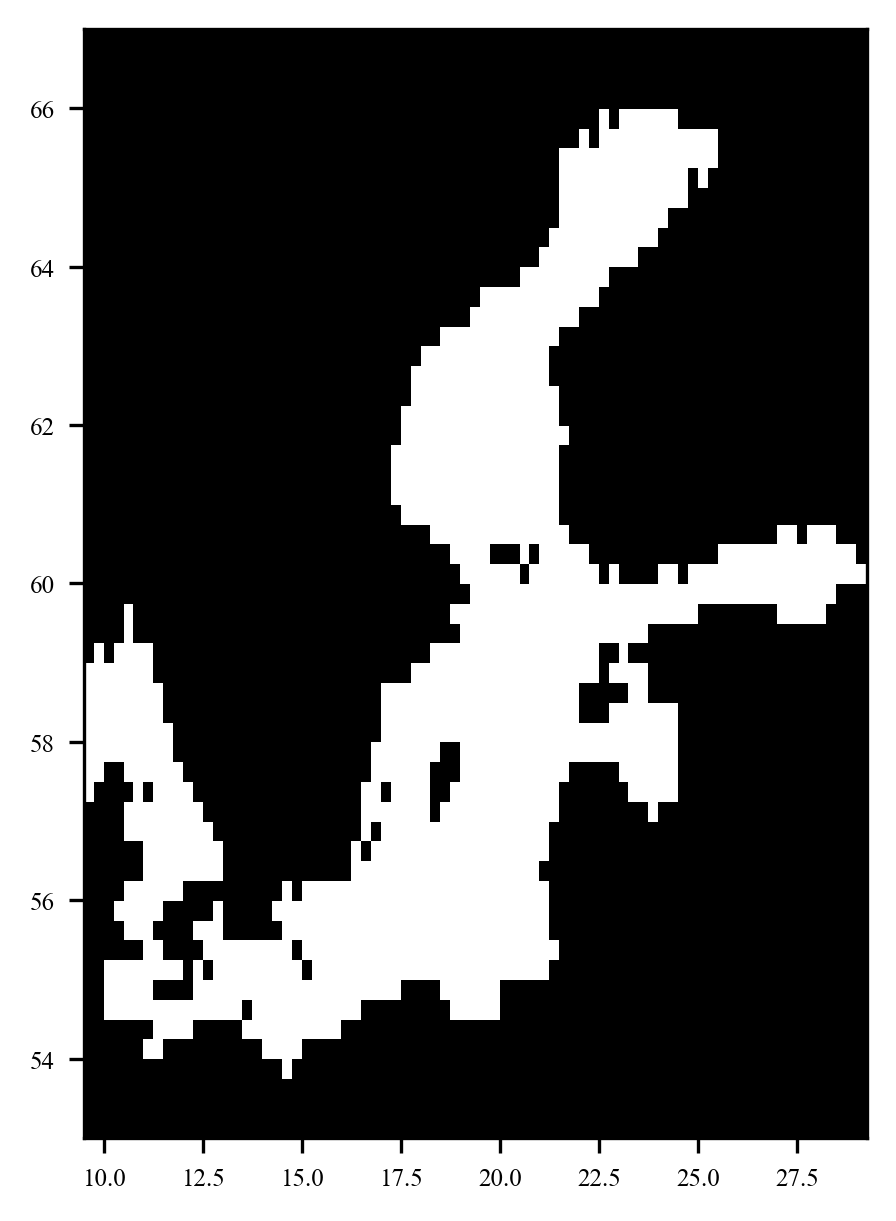

PyObject <matplotlib.collections.PolyCollection object at 0x7f0bf0992510>

In [13]:
figure()
gca().set_aspect(aspect_ratio)
gca().tick_params("both", labelsize=6)
pcolor(bx, by ,surfmask', cmap=PyPlot.cm.binary_r)

In [14]:
mask = falses(size(b,1),size(b,2),length(depthr))
for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = (b[i,j] >= depthr[k]) && surfmask[i,j]
        end
    end
end
@show size(mask)

size(mask) = (80, 57, 6)


(80, 57, 6)

## Analysis
### Background

In [15]:
# year and month-list for background analysis
yearlist = [1900:1989,1990:2017];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TSbackground = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

#### Analysis parameters

In [16]:
sz = (length(lonr), length(latr), length(depthr));
lenx = fill(200_000.,sz)   # 200 km
leny = fill(200_000.,sz)   # 200 km
lenz = [min(max(30.,depthr[k]/150),300.) for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]]
len = (lenx, leny, lenz);
epsilon2 = 0.1;

filenamebackground = "Water_body_$(replace(varname," "=>"_"))_Baltic_background.4Danl.nc"
filename = "Water_body_$(replace(varname," "=>"_"))_Baltic.4Danl.nc"

"Water_body_salinity_Baltic.4Danl.nc"

#### Metadata for the netCDF file

Remove the background file if it already exists, and create the figure directory if needed.

In [17]:
if isfile(filenamebackground)
    rm(filenamebackground) # delete the previous analysis
    @info "Removing file $filenamebackground"
end

figdir = "./Baltic/figures/"
if ~(isdir(figdir))
    mkpath(figdir);
    @info "Creating directory $(figdir)"
end
solver = :direct

┌ Info: Removing file Water_body_salinity_Baltic_background.4Danl.nc
└ @ Main In[17]:3


:direct

Let's define a plotting function that well be applied at each time and depth level.

In [18]:
function plotres(timeindex, sel, fit, erri)
    tmp = copy(fit)
    nx,ny,nz = size(tmp)
    for i in 1:nz
        figure("Baltic analysis")
        ax = subplot(1,1,1)
        ax.tick_params("both",labelsize=6)
        ylim(minimum(latr) - Δy, maximum(latr) + Δy);
        xlim(minimum(lonr) - Δx, maximum(lonr) + Δx);
        title("Depth: $(depthr[i]) \n Time index: $(timeindex)", fontsize=6)
        pcolor(lonr.-Δx/2.,latr.-Δy/2, permutedims(tmp[:,:,i], [2,1]);
               vmin = 0., vmax = 15.)
        cb = colorbar(extend="max", orientation="vertical", shrink=0.8)
        cb.ax.tick_params(labelsize=8)

        contourf(bx,by,permutedims(b,[2,1]), levels = [-1e5,0], colors = [[.5,.5,.5]])
        gca().set_aspect(aspect_ratio)

        figname = varname * @sprintf("_%02d",i) * @sprintf("_%03d.png",timeindex)
        PyPlot.savefig(joinpath(figdir, figname), dpi=300, bbox_inches="tight");
        PyPlot.close_figs()
    end
end

plotres (generic function with 1 method)

#### Background analysis
We now have all the input to prepare the background field with `diva3d`.     
The analysis has 8 times steps: 4 seasons times 2 periods (1900-1989 and 1990-2017).

In [24]:
dbinfo = @time diva3d((lonr,latr,depthr,TSbackground),
           (obslon,obslat,obsdepth,obstime), obsval,
           len, epsilon2,
           filenamebackground,varname,
           bathname=bathname,
           mask = mask,
           fitcorrlen = false,
           niter_e = 2,
           solver = solver,
           MEMTOFIT = 120,
       );

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:330
┌ Info: Time step 1 / 8
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: Time step 2 / 8
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: scaled correlation length (min,max) in dimensi

108.888219 seconds (177.48 M allocations: 44.495 GiB, 4.11% gc time)


### Final analysis
#### Parameters
We define the periods of interest for the final climatology.

In [25]:
yearlist = [1970:1979,1980:1989,1990:1999,2000:2009];
monthlist = [[1,2,3],[4,5,6],[7,8,9],[10,11,12]];  # Seasonal climatology
TS = DIVAnd.TimeSelectorYearListMonthList(yearlist,monthlist);

We remove the final netCDF file if it exists.

In [26]:
if isfile(filename)
    rm(filename) # delete the previous analysis
    @info "Removing file $filename"
end

Now we can perform the analysis using background field, defined through the option      
`background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground)`:      
* `filenamebackground` is the name of the netCDF that you have created with the background
* `varname` is the name of the variable as written in the background netCDF and
* `TSbackground` is the *TimeSelector` object used to compute the background.

With these options set, the new analysis will select the correct background according to the considered period.     
We now have 16 time steps: 4 seasons times 4 year periods.

In [28]:
dbinfo = @time diva3d((lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime), obsval,
    len, epsilon2,
    filename,varname,
    bathname=bathname,
    plotres = plotres,
    mask = mask,
    fitcorrlen = false,
    niter_e = 2,
    background = DIVAnd.backgroundfile(filenamebackground,varname,TSbackground),
    solver = solver,
    MEMTOFIT = 120,
);

@show length(obslat);

┌ Info: Creating netCDF file
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:330
┌ Info: Time step 1 / 16
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: analysis time index 1 uses the backgrond time index 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/utils.jl:736
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: Time s

┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 2: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: scaled correlation length (min,max) in dimension 3: (30.0, 30.0)
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:567
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: number of windows: 1
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAndgo.jl:111
┌ Info: Time step 11 / 16
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/diva.jl:382
┌ Info: analysis time index 11 uses the backgrond time index 7
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/utils.jl:736
┌ Info: scaled correlation length (min,max) in dimension 1: (200000.0, 200000.0)
└ @ DIVAnd /home/ctroupin/.juli

150.182604 seconds (57.10 M allocations: 39.276 GiB, 0.31% gc time)
length(obslat) = 11180368


In [23]:
filename

"Water_body_salinity_Baltic.4Danl.nc"